# Predicting ROE over the next 2 years: 2012 vs 2014

In [96]:
import os
import pandas as pd
import numpy as np
import sys
import patsy
import statsmodels.api as sm
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import sklearn.metrics as metrics
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    auc,
    confusion_matrix,
    roc_auc_score,
    mean_squared_error,
)
from sklearn.ensemble import RandomForestClassifier
from plotnine import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings

warnings.filterwarnings("ignore")

Helper functions

In [97]:
import copy

####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start, stop, by, round_n=3):
    return [round(x, round_n) for x in list(np.arange(start, stop, by))]


def skew(l, round_n=3):
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

def create_calibration_plot(
    data,
    file_name,
    prob_var,
    actual_var,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    plot = (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(
            color=color[0],
            size=1,
            alpha=0.7,
            show_legend=False,
            na_rm=True,
        )
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )

    return plot


def poly(x, degree=1):
    """
    Fit Polynomial
    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

In [98]:
data = pd.read_csv("fin-bisnode_firms_cleaned.csv")

In [99]:
data.year.unique()

array([2013], dtype=int64)

### Define regression helper functions

In [100]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": np.asscalar(model.intercept_)},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

### Defining the variables

In [101]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]

engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)


hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]
financial_extras = [
    "ROE",
    "EBITDA",
    "ROA",
    "sales_per_tot_assets",
    "liquidity_rate",
    "own_equity_rate",
]

In [102]:
# Turning the category variables into dummy columns and drop first level

ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)", data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(["C(ind2_cat)[26.0]"], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)", data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(["C(m_region_loc)[Central]"], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)", data, return_type="dataframe")
urban_mmat = urban_mmat.drop(["C(urban_m)[1.0]"], axis=1)

In [103]:
# Define X1
basevars = data[
    ["sales_mil_log", "sales_mil_log_sq", "sale_growth", "profit_loss_year_pl"]
]
X1 = pd.concat([basevars, ind2_catmat], axis=1)
# Define X2
X2additional_vars = data[
    [
        "fixed_assets_bs",
        "share_eq_bs",
        "curr_liab_bs",
        "curr_liab_bs_flag_high",
        "curr_liab_bs_flag_error",
        "age",
        "foreign_management",
    ]
]
X2 = pd.concat([X1, X2additional_vars], axis=1)
# Define X3
firm = pd.concat(
    [data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1
)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar], firm], axis=1)
# Define X4
X4 = pd.concat(
    [
        data[
            ["sales_mil_log", "sales_mil_log_sq"]
            + engvar
            + engvar2
            + engvar3
            + hr
            + qualityvars
            + financial_extras
        ],
        firm,
    ],
     axis=1,
)

In [104]:
# Define X5
# Creat matrix for interactions1 variables
int1mat = patsy.dmatrix(
    "0 + C(ind2_cat):age + C(ind2_cat):age2 + C(ind2_cat):sale_growth \
                + C(ind2_cat):sales_mil_log + C(ind2_cat):ceo_age + C(ind2_cat):foreign_management \
                + C(ind2_cat):female + C(ind2_cat):C(urban_m) + C(ind2_cat):labor_avg_mod",
    data,
    return_type="dataframe",
)
# Drop first level to get k-1 dummies out of k categorical levels
for col in int1mat.columns:
    if col.startswith("C(ind2_cat)[26.0]") or col.endswith("C(urban_m)[1.0]"):
        int1mat = int1mat.drop([col], axis=1)

# Creat matrix for interactions2 variables
int2mat = patsy.dmatrix(
    "0 + sales_mil_log:age + sales_mil_log:female + sales_mil_log:profit_loss_year_pl \
                + sales_mil_log:foreign_management",
    data,
    return_type="dataframe",
)
X5 = pd.concat([X4, int1mat, int2mat], axis=1)

In [105]:
# Define logitvars for LASSO
logitvars = pd.concat([X4, int1mat, int2mat], axis=1)

In [106]:
# Define rfvars for RF (without interactions and modified features)
rfvars = pd.concat([data[["sales_mil"] + rawvars + hr + qualityvars], firm], axis=1)

In [107]:
y = data["high_roe_firm"]
target = "high_roe_firm"

In [108]:
data[["high_growth_firm","high_roe_firm"]].corr()

,high_growth_firm,high_roe_firm
high_growth_firm,1.000000,0.171379
high_roe_firm,0.171379,1.000000


### Create train and holdout sets

In [109]:
index_train, index_holdout= train_test_split(
    data.index.values, train_size=round(0.7*len(data.index)), random_state=44)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

In [110]:
print('Total set')
print(data[target].value_counts(normalize=True))
print('Train set')
print(data.iloc[index_train][target].value_counts(normalize=True))
print('Holdout set')
print(data.iloc[index_holdout][target].value_counts(normalize=True))

Total set
0    0.79121
1    0.20879
Name: high_roe_firm, dtype: float64
Train set
0    0.79288
1    0.20712
Name: high_roe_firm, dtype: float64
Holdout set
0    0.787313
1    0.212687
Name: high_roe_firm, dtype: float64


## Predict probabilities with Logit and Lasso Logit

In [111]:
# Specify cross-validation method

k = KFold(n_splits=5, shuffle=True, random_state=42)

In [112]:
# No regularisation needed so setting the paremeter to very high value

C_value_logit=[1e20]

In [113]:
# Train Logit Models 
logit_model_vars = [
    X1.iloc[index_train],
    X2.iloc[index_train],
    X3.iloc[index_train],
    X4.iloc[index_train],
    X5.iloc[index_train],
]

logit_models = dict()
CV_RMSE_folds = dict()

for i in range(len(logit_model_vars)):
    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    logit_models["X" + str(i + 1)] = LRCV_brier.fit(logit_model_vars[i], y_train)
    # Calculate RMSE on test for each fold
    CV_RMSE_folds["X" + str(i + 1)] = np.sqrt(
        -1 * (logit_models["X" + str(i + 1)].scores_[1])
    ).tolist()

### Lasso Logit Model

In [114]:
normalized_logitvars=pd.DataFrame(StandardScaler().fit_transform(logitvars.iloc[index_train]))
normalized_logitvars.columns=logitvars.columns

In [115]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [1 / (l * n_obs) for l in lambdas]

logLasso = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="accuracy",
    solver="liblinear",
    random_state=42,
)

In [116]:
logit_models["LASSO"] = logLasso.fit(normalized_logitvars, y_train)

In [117]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.001052,0.792880
1,0.046416,0.002266,0.794815
2,0.021544,0.004883,0.804830
3,0.010000,0.010520,0.807860
4,0.004642,0.022665,0.810974
5,0.002154,0.048830,0.811815
6,0.001000,0.105201,0.811563
7,0.000464,0.226649,0.811731
8,0.000215,0.488300,0.812825
9,0.000100,1.052011,0.812236


In [118]:
best_lambda = cv_summary_lasso.sort_values('mean_cv_score', ascending = False).iloc[0,0]

In [119]:
# refit with negative brier score so we have RMSE values for the same cv split
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)
logLasso_brier_fitted = logLasso_brier.fit(normalized_logitvars, y_train)

In [120]:
for i, l in enumerate(lambdas):
    if l == best_lambda:
        best_lambda_i = i
        CV_RMSE_folds["LASSO"] = np.sqrt(
            -1 * (logLasso_brier_fitted.scores_[1][:, i])
        ).tolist()

## Classification of Logit and Logit Lasso Models

### No loss function

In [121]:
# Calculate AUC for each folds --------------------------------
CV_AUC_folds = dict()

# Refit logit models with AUC so we have AUC values for the same cv split
for i in range(len(logit_model_vars)):
    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )
    LRCV_auc_fit = LRCV_auc.fit(logit_model_vars[i], y_train)
    
    # Calculate AUC on test for each fold
    CV_AUC_folds["X" + str(i + 1)] = LRCV_auc_fit.scores_[1][:, 0].tolist()

In [122]:
# Refit with AUC so we have AUC values for the same cv split
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)
CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][:, best_lambda_i].tolist()

In [123]:
# For each model: average RMSE and average AUC for models ----------------------------------
CV_RMSE = dict()
CV_AUC = dict()
nvars = dict()

for key in logit_models:
    CV_RMSE[key] = np.mean(CV_RMSE_folds[key])
    CV_AUC[key] = np.mean(CV_AUC_folds[key])

for key in logit_models:
    if key != "LASSO":
        nvars[key] = logit_models[key].n_features_in_
    else:
        nvars[key] = sum(x != 0 for x in logit_models[key].coef_[0].tolist())

In [124]:
logit_summary1 = np.transpose(
    pd.DataFrame.from_dict([nvars, CV_RMSE, CV_AUC], orient="columns")
)
logit_summary1.columns = ["Number of predictors", "CV RMSE", "CV AUC"]

In [125]:
logit_summary1

,Number of predictors,CV RMSE,CV AUC
X1,11.0,0.394494,0.672971
X2,18.0,0.380899,0.730337
X3,31.0,0.379623,0.731629
X4,81.0,0.367663,0.775151
X5,155.0,0.366817,0.776228
LASSO,134.0,0.365861,0.778229


### Evaluate the performance of the best model on the holdout set

In [126]:
best_model = logit_models["X4"]
data_train = X4.iloc[index_train]

best_model.fit(data_train,y_train)
best_model_X_holdout = X4.iloc[index_holdout]

logit_predicted_probabilities_train = best_model.predict_proba(data_train)[
    :, 1
]

logit_predicted_probabilities_holdout = best_model.predict_proba(best_model_X_holdout)[
    :, 1
]
best_rmse_holdout = np.sqrt(
    metrics.mean_squared_error(y_holdout, logit_predicted_probabilities_holdout)
)
round(best_rmse_holdout, 3)

0.366

In [127]:
# Discrete ROC (with thresholds in steps) on holdout

thresholds = seq(0.01, 0.7, by=0.05)
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(logit_predicted_probabilities_holdout < thr, 0, 1)
    cm_thr = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [128]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

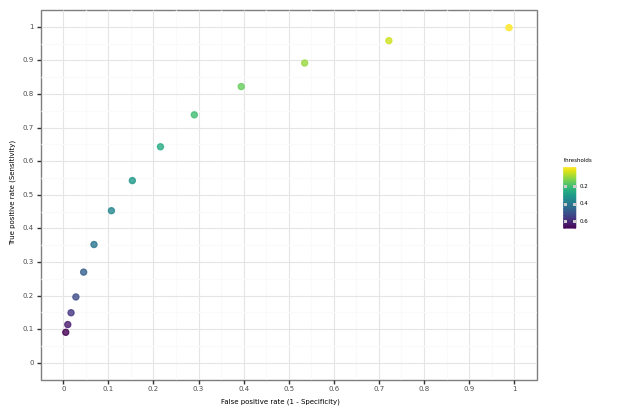

<ggplot: (175797115067)>

In [129]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=2, alpha=0.8)
    + scale_color_continuous(trans="reverse")
    + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1.01, by=0.1))
    + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1.01, by=0.1))
    + theme_bw()
    + theme(
        legend_position="right",
        axis_text=element_text(size=5),
        axis_title=element_text(size=5),
        legend_text=element_text(size=4),
        legend_title=element_text(size=4),
        legend_key_size=6,
    )
)

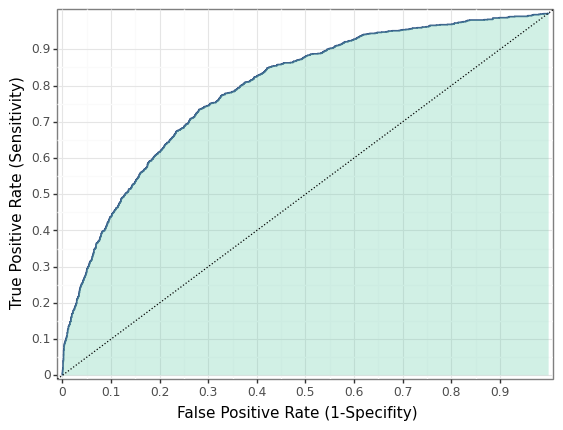

<ggplot: (175691701417)>

In [130]:
# Continuous ROC on holdout with best model (Logit 4) -------------------------------------------

create_roc_plot(y_holdout, logit_predicted_probabilities_holdout)

In [131]:
# Confusion table with different tresholds 

# Default: the threshold 0.5 is used to convert probabilities to binary classes
logit_class_prediction = best_model.predict(best_model_X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " low growth: ", counts[0])
print(values[1], " high growth: ", counts[1])

0  low growth:  4744
1  high growth:  348


In [132]:
# Confusion matrix: summarize different type of errors and successfully predicted cases
# positive = "yes": explicitly specify the positive case

cm_object1 = confusion_matrix(y_holdout, logit_class_prediction, labels=[0, 1])
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm1


,Predicted low growth,Predicted high growth
Actul low growth,3888,121
Actual high growth,856,227


In [133]:
# A sensible choice: mean of predicted probabilities
mean_predicted_default_prob = np.mean(logit_predicted_probabilities_holdout)
round(mean_predicted_default_prob, 3)

0.205

In [134]:
holdout_prediction = np.where(
    logit_predicted_probabilities_holdout < mean_predicted_default_prob, 0, 1
)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,2802,1207
Actual high growth,277,806


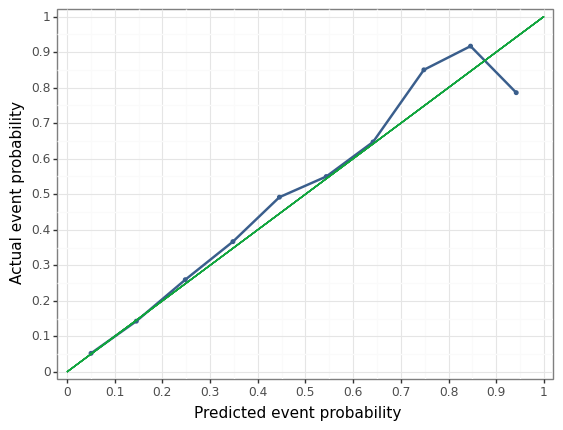

<ggplot: (175796470297)>

In [135]:
# Calibration curve -----------------------------------------------------------
# How well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([best_model_X_holdout, y_holdout], axis=1)
holdout["best_logit_no_loss_pred"] = logit_predicted_probabilities_holdout
create_calibration_plot(
    holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_no_loss_pred",
    actual_var=target,
    y_lab="Actual event probability",
    #breaks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],
)

In [136]:
data_train = data_train.assign(
    best_logit_no_loss_pred=logit_predicted_probabilities_train, target=y_train
)

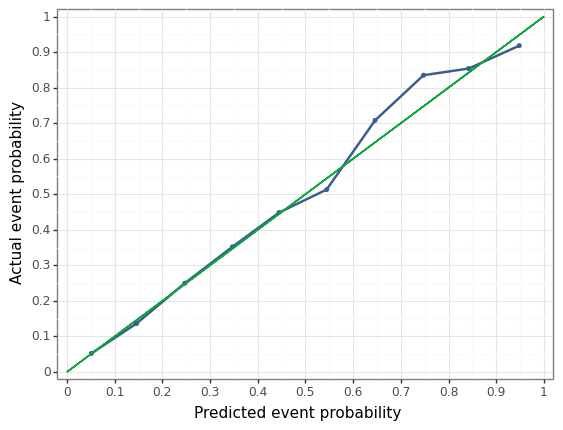

<ggplot: (175796246519)>

In [137]:
create_calibration_plot(
    data_train,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_no_loss_pred",
    actual_var="target",
    y_lab="Actual event probability",
        #breaks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],
)


In [138]:
target

'high_roe_firm'

<AxesSubplot: >

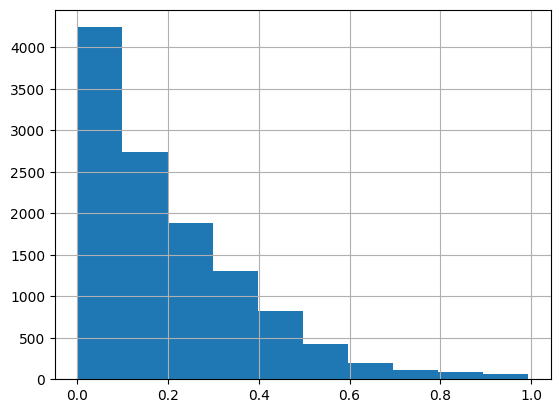

In [139]:
data_train.best_logit_no_loss_pred.hist()

<AxesSubplot: >

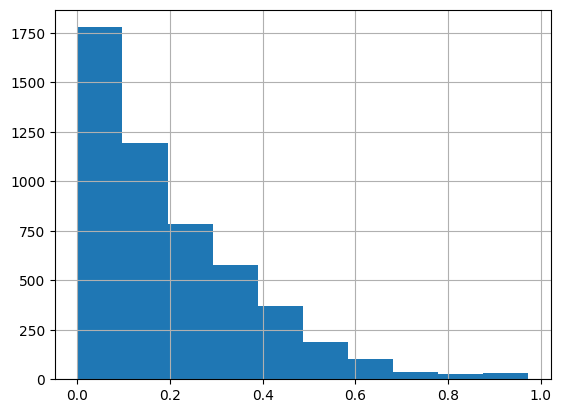

In [140]:
holdout.best_logit_no_loss_pred.hist()

In [141]:
coef_matrix(best_model_X_holdout,best_model).sort_values(by=["coefficient"])

,variable,coefficient
15,profit_loss_year_pl,-2.619264
39,profit_loss_year_pl_flag_low,-2.194528
20,share_eq_bs_quad,-1.941155
13,inventories_pl,-1.778213
42,inc_bef_tax_pl_flag_high,-1.372194
...,...,...
60,balsheet_notfullyear,1.097073
19,profit_loss_year_pl_quad,1.145790
48,share_eq_bs_flag_zero,1.565424
38,inc_bef_tax_pl_flag_low,2.936078


In [142]:
holdout.loc[lambda x: x[target]==1,"best_logit_no_loss_pred"].mean()

0.35659991648235

In [143]:
holdout.loc[lambda x: x[target]==0,"best_logit_no_loss_pred"].mean()

0.16395643940401325

## Classification with a loss function

In [144]:
# Introduce loss function
# Relative cost of of a false negative classification (as compared with a false positive classification)
FP = 2
FN = 1
cost = FN / FP
# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = y_train.sum() / len(y_train)

In [145]:
# Draw ROC Curve and find optimal threshold with loss function --------------------------
# The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []
    if model_name != "LASSO":
        X = logit_model_vars[i]
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = y_train.iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [146]:
logit_summary2 = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
logit_summary2["Threshold for Fold5"] = fold5_threshold.values()
logit_summary2["Avg expected loss"] = expected_loss_cv.values()
logit_summary2["Expected loss for Fold5"] = fold5_expected_loss.values()

In [147]:
expected_loss_cv

{'X1': 0.20695211121168205,
 'X2': 0.20510047183374908,
 'X3': 0.20156529535999454,
 'X4': 0.19542228483120364,
 'X5': 0.1947485300346049,
 'LASSO': 0.19382306446883643}

In [148]:
logit_summary2

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,X1,1.208807,1.620570,0.206952,0.207492
1,X2,0.627592,0.607346,0.205100,0.204125
2,X3,0.567492,0.532882,0.201565,0.198653
3,X4,0.594286,0.587983,0.195422,0.195286
4,X5,0.627937,0.625553,0.194749,0.194444
5,LASSO,0.677316,0.720428,0.193823,0.193182


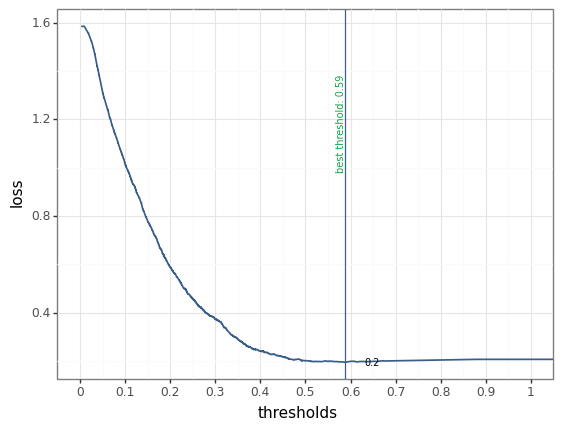

<ggplot: (175792934054)>

In [149]:
# Create loss plot based on Fold5 in CV ----------------------------------------------
# Select model to plot
model_to_plot = "X4"
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

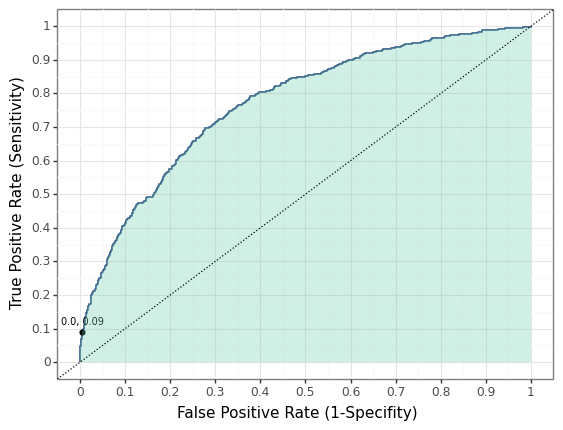

<ggplot: (175691854213)>

In [150]:
# Create roc plot plot based on Fold5 in CV ----------------------------------------------
# Select model to plot
model_to_plot = "X4"
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)

In [151]:
# Pick best model based on average expected loss ----------------------------------
# X5
best_logit_optimal_treshold = best_thresholds_cv["X4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    logit_predicted_probabilities_holdout < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.203

In [152]:
cm_object3 = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted higth growth"],
)
cm3

,Predicted low growth,Predicted higth growth
Actual low growth,3964,45
Actual high growth,945,138


# Random Forest Model

In [153]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

### Predicting probabilities

In [154]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
}

In [155]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(prob_forest, grid, cv=k, refit='accuracy',
                                scoring = ['accuracy', 'roc_auc', 'neg_brier_score'], n_jobs=-1)

In [156]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [157]:
# Create CV summary table

cv_accuracy = np.zeros([6])
for i in range(5):
    cv_accuracy = (
        cv_accuracy + prob_forest_fit.cv_results_["split" + str(i) + "_test_accuracy"]
    )
cv_accuracy = cv_accuracy / 5

cv_auc = np.zeros([6])
for i in range(5):
    cv_auc = cv_auc + prob_forest_fit.cv_results_["split" + str(i) + "_test_roc_auc"]
cv_auc = cv_auc / 5

cv_rmse = np.zeros([6])
for i in range(5):
    cv_rmse = (
        cv_rmse
        + np.sqrt(
            -1
            * (prob_forest_fit.cv_results_["split" + str(i) + "_test_neg_brier_score"])
        ).tolist()
    )
cv_rmse = cv_rmse / 5

prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_accuracy": cv_accuracy,
        "cv_auc": cv_auc,
        "cv_rmse": cv_rmse,
    }
)

In [158]:
prob_forest_cv_results

,max_features,min_samples_split,cv_accuracy,cv_auc,cv_rmse
0,5,11,0.815771,0.797411,0.361709
1,5,16,0.814677,0.798188,0.361558
2,6,11,0.817118,0.801007,0.359910
3,6,16,0.815182,0.800211,0.360459
4,7,11,0.817538,0.801255,0.359386
5,7,16,0.817539,0.801801,0.359368


In [159]:
# Obtain optimal parameter values
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

In [160]:
# Get average (ie over the folds) RMSE and AUC ------------------------------------
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

CV_RMSE["rf_p"] = prob_forest_best_results.cv_rmse.values[0]
CV_AUC["rf_p"] = prob_forest_best_results.cv_auc.values[0]

In [161]:
# Get fold level RMSE and AUC ------------------------------------

CV_RMSE_folds_rf_p = list()
for i in range(5):
    rmse = np.sqrt(
        -1 * (prob_forest_fit.cv_results_["split" + str(i) + "_test_neg_brier_score"])
    ).tolist()[prob_forest_best_results_index]
    CV_RMSE_folds_rf_p.append(rmse)
CV_RMSE_folds["rf_p"] = CV_RMSE_folds_rf_p

CV_AUC_folds_rf_p = list()
for i in range(5):
    rmse = prob_forest_fit.cv_results_["split" + str(i) + "_test_roc_auc"][
        prob_forest_best_results_index
    ]
    CV_AUC_folds_rf_p.append(rmse)
CV_AUC_folds["rf_p"] = CV_AUC_folds_rf_p

In [162]:
best_mtry = 7
best_min_node_size = 16

### Use loss function to search for best thresholds and expected loss over folds

In [163]:
best_thresholds = list()
expected_loss = list()

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = y_train.iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = y_train.iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [164]:
fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [165]:
expected_loss_cv["rf_p"] = np.mean(expected_loss)
best_thresholds_cv["rf_p"] = np.mean(best_thresholds)

In [166]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(CV_RMSE["rf_p"], 3)],
        "CV AUC": [round(CV_AUC["rf_p"], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["rf_p"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["rf_p"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.359,0.802,0.575,0.553,0.191,0.189


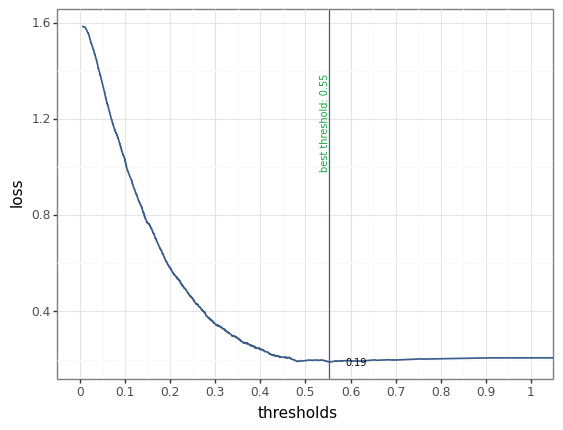

<ggplot: (175691391239)>

In [167]:
# Create plots based on Fold5 in CV ----------------------------------------------
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

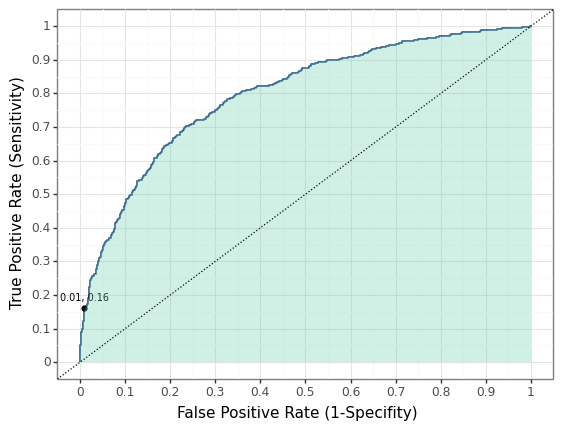

<ggplot: (175691034161)>

In [168]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [169]:
# Take model to holdout and estimate RMSE, AUC and expected loss ------------------------------------
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.359

In [170]:
# ROC AUC  on holdout
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.815

In [171]:
# Get expected loss on holdout
holdout_treshold = np.where(rf_predicted_probabilities_holdout < best_thresholds_cv['rf_p'], 0, 1)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0,1]).ravel()
expected_loss_holdout = (fp*FP + fn*FN)/len(y_holdout)
round(expected_loss_holdout, 3)

0.2

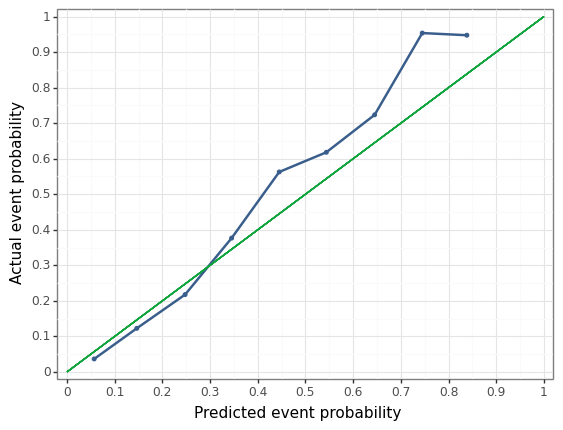

<ggplot: (175796289259)>

In [172]:
# Calibration curve -----------------------------------------------------------
# how well do estimated vs actual event probabilities relate to each other?

holdout = pd.concat([rfvars_holdout, y_holdout], axis=1)
holdout["best_rf_no_loss_pred"] = prob_forest_fit_best.predict_proba(rfvars_holdout)[:,1]
create_calibration_plot(
    holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_rf_no_loss_pred",
    actual_var=target,
    y_lab="Actual event probability",
)

## Compare the performance of all models

In [173]:
nvars['rf_p'] = len(rfvars.columns)

In [174]:
summary_results = pd.DataFrame(
    {
        "Model": list(nvars.keys()),
        "Number of predictors": list(nvars.values()),
        "CV RMSE": list(CV_RMSE.values()),
        "CV AUC": list(CV_AUC.values()),
        "CV threshold": list(best_thresholds_cv.values()),
        "CV expected Loss": list(expected_loss_cv.values()),
    }
)

In [175]:
summary_results.round(3)

,Model,Number of predictors,CV RMSE,CV AUC,CV threshold,CV expected Loss
0,X1,11,0.394,0.673,1.209,0.207
1,X2,18,0.381,0.730,0.628,0.205
2,X3,31,0.380,0.732,0.567,0.202
3,X4,81,0.368,0.775,0.594,0.195
4,X5,155,0.367,0.776,0.628,0.195
5,LASSO,134,0.366,0.778,0.677,0.194
6,rf_p,43,0.359,0.802,0.575,0.191


### Refit best model on whole train dataset

In [176]:
best_prob_forest = RandomForestClassifier(
    criterion="gini",
    max_features=7,
    min_samples_split=16,
    random_state=42,
    n_estimators=500,
    oob_score=True,
)

In [177]:
prob_forest_fit = best_prob_forest.fit(rfvars_train, y_train)

best_prob_forest_holdout_pred = prob_forest_fit.predict(rfvars_holdout)

In [178]:
holdout_prediction = np.where(
    best_prob_forest_holdout_pred < fold5_threshold_rf, 0, 1
)
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1])
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,3912,97
Actual high growth,846,237


In [179]:
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1],normalize="pred")
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,0.822194,0.290419
Actual high growth,0.177806,0.709581


In [180]:
cm_object2 = confusion_matrix(y_holdout, holdout_prediction, labels=[0, 1],normalize="all")
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,0.768264,0.019049
Actual high growth,0.166143,0.046544


## Predict and calculate profit on "live" data, year 2014

In [181]:
live_data = pd.read_csv("bisnode_firms_cleaned.csv")

# Creat dummy columns from category variables and drop first level
ind2_catmat = patsy.dmatrix("0 + C(ind2_cat)", live_data, return_type="dataframe")
ind2_catmat = ind2_catmat.drop(["C(ind2_cat)[26.0]"], axis=1)

m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)", live_data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(["C(m_region_loc)[Central]"], axis=1)

urban_mmat = patsy.dmatrix("0 + C(urban_m)", live_data, return_type="dataframe")
urban_mmat = urban_mmat.drop(["C(urban_m)[1.0]"], axis=1)
firm = pd.concat(
    [live_data[["age", "age2", "new"]], ind2_catmat, m_region_locmat, urban_mmat], axis=1
)

# Define rfvars for RF (no interactions, no modified features)
rfvars_live = pd.concat([live_data[["sales_mil"] + rawvars + hr + qualityvars], firm], axis=1)
y_live = live_data["high_roe_firm"]

In [182]:
best_prob_forest_live_pred = prob_forest_fit.predict(rfvars_live)

In [183]:
live_prediction = np.where(
    best_prob_forest_live_pred < fold5_threshold_rf, 0, 1
)
cm_object2 = confusion_matrix(y_live, live_prediction, labels=[0, 1])
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,11282,367
Actual high growth,2517,719


In [184]:
cm_object2 = confusion_matrix(y_live, live_prediction, labels=[0, 1],normalize="pred")
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,0.817595,0.337937
Actual high growth,0.182405,0.662063


In [185]:
cm_object2 = confusion_matrix(y_live, live_prediction, labels=[0, 1],normalize="all")
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual low growth", "Actual high growth"],
    columns=["Predicted low growth", "Predicted high growth"],
)
cm2

,Predicted low growth,Predicted high growth
Actual low growth,0.757944,0.024656
Actual high growth,0.169096,0.048304


### Calculating actual return from ROE

In [186]:
live_data = live_data.assign(buy = live_prediction)

invested_roes = live_data.loc[lambda x: x["buy"] == 1,"ROE_target"]

invested_roes = np.where(invested_roes< -1,-1,invested_roes)

invested_roes = np.where(invested_roes> 1,1,invested_roes)

In [187]:
pd.Series(invested_roes).describe()

count    1086.000000
mean        0.447280
std         0.507064
min        -1.000000
25%         0.185159
50%         0.463288
75%         0.988868
max         1.000000
dtype: float64

In [188]:
#If an investor invested 100 thousand, what would be his return in 2014?

(1+invested_roes.mean())*100000

144728.0042918126